# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/lmfit-0.9.11-py3.6.egg', '/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython']


Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.8.0


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos= npzfile['arr_0']
conjunto_datos=conjunto_datos[:,:]
# npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# npzfile.files

# conjunto_datos2= npzfile['arr_0']

# conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
# print(conjunto_datos.shape)
# conjunto_datos=conjunto_datos1
print(conjunto_datos.shape)
# print(conjunto_datos[:10,6:26])

(50000, 3518)


## Network parameters:

In [4]:
batch_size = 500
nb_classes = 10
nb_epoch = 250

# input image dimensions
img_rows, img_cols = 20, 35
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [5]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
# n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


idea=conjunto_datos[:,6:3506]
veamos=idea.reshape(idea.shape[0],175, 20)
veamos2=np.zeros([idea.shape[0],20,175])
veamos2_3=np.zeros([idea.shape[0],20,525])
sector2=np.zeros([idea.shape[0],20,img_cols])
veamos3=np.zeros([idea.shape[0],175])
# for i in range(idea.shape[0]):
for i in range(idea.shape[0]):
    veamos2[i]=np.reshape(veamos[i].transpose(), [20,175])
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2[i]=veamos2_3[i,:,indice_inferior:indice_superior]
    

print('sector shape:', sector2.shape)
conjunto_datos_nuevo=sector2.reshape(sector2.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo:', conjunto_datos_nuevo.shape)

50000
conjunto_datos shape: (50000, 3518)
194.99950513267174
sector shape: (50000, 20, 35)
conjunto_datos_nuevo: (50000, 700)


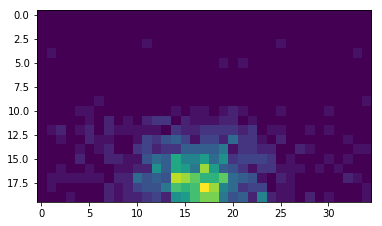

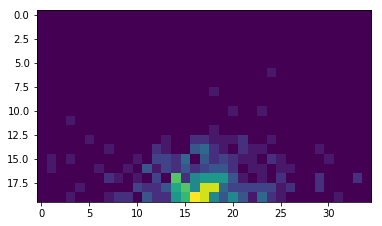

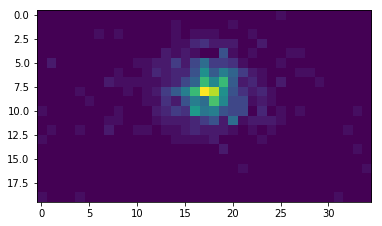

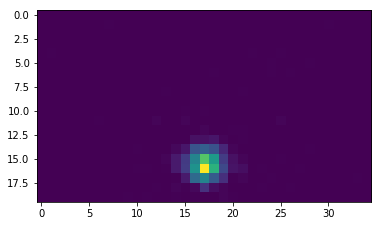

In [6]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2.shape[0])
    plt.imshow(sector2[idea], cmap='viridis')
    plt.show()

In [7]:
tr_size=40
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos[:,0:3],conjunto_datos_nuevo), axis=1)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

20000
10000
20000
(8655, 700)
(3929, 700)
(2550, 700)
(2132, 700)
(2734, 700)


In [8]:


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [9]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (20000, 20, 35, 1)
20000 train samples
10000 validation samples
20000 test samples


Display 20 random training images using image

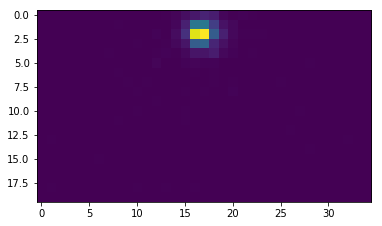

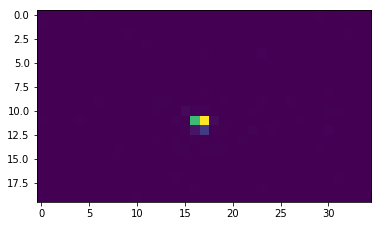

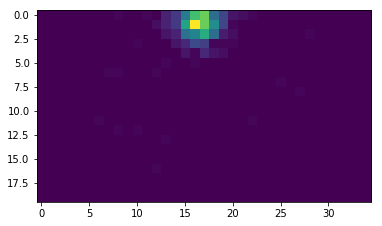

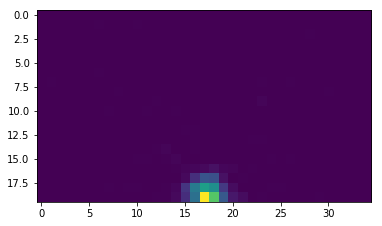

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [11]:
model = Sequential()

model.add(Conv2D(16, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(img_rows,img_cols,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

experimento="CNN_original_sector_{}x{}".format(img_rows,img_cols)
algoritmo='Nadam'

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error',
              optimizer=algoritmo)



Show a summary of the model parameters. 

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 35, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 35, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 35, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 17, 16)        4112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 17, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 17, 16)        0         
__________

And now train the model and evaluate on the test set. 

In [13]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                    callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/250
20000/20000 [==============================] - 5s 225us/step - loss: 12214.4452 - val_loss: 3059.2477
Epoch 2/250
20000/20000 [==============================] - 1s 34us/step - loss: 270.9989 - val_loss: 553.6357
Epoch 3/250
20000/20000 [==============================] - 1s 34us/step - loss: 5.4885 - val_loss: 389.9616
Epoch 4/250
20000/20000 [==============================] - 1s 34us/step - loss: 4.9578 - val_loss: 157.6938
Epoch 5/250
20000/20000 [==============================] - 1s 35us/step - loss: 3.8231 - val_loss: 49.4030
Epoch 6/250
20000/20000 [==============================] - 1s 40us/step - loss: 3.1934 - val_loss: 30.1634
Epoch 7/250
20000/20000 [==============================] - 1s 40us/step - loss: 3.0722 - val_loss: 12.3529
Epoch 8/250
20000/20000 [==============================] - 1s 35us/step - loss: 2.6402 - val_loss: 18.1359
Epoch 9/250
20000/20000 [==============================] - 1s 37us/step - loss: 2.

Epoch 77/250
20000/20000 [==============================] - 1s 41us/step - loss: 1.2321 - val_loss: 3.5680
Epoch 78/250
20000/20000 [==============================] - 1s 36us/step - loss: 1.1739 - val_loss: 8.6393
Epoch 79/250
20000/20000 [==============================] - 1s 35us/step - loss: 1.1099 - val_loss: 1.2696
Epoch 80/250
20000/20000 [==============================] - 1s 38us/step - loss: 1.0949 - val_loss: 1.3287
Epoch 81/250
20000/20000 [==============================] - 1s 41us/step - loss: 1.1969 - val_loss: 3.4052
Epoch 82/250
20000/20000 [==============================] - 1s 36us/step - loss: 1.0314 - val_loss: 2.1163
Epoch 83/250
20000/20000 [==============================] - 1s 36us/step - loss: 1.2339 - val_loss: 2.4998
Epoch 84/250
20000/20000 [==============================] - 1s 40us/step - loss: 1.2172 - val_loss: 2.7891
Epoch 85/250
20000/20000 [==============================] - 1s 37us/step - loss: 1.1267 - val_loss: 2.3826
Epoch 86/250
20000/20000 [===========

20000/20000 [==============================] - 1s 36us/step - loss: 1.3873 - val_loss: 1.4436
Epoch 154/250
20000/20000 [==============================] - 1s 36us/step - loss: 0.9311 - val_loss: 0.8008
Epoch 155/250
20000/20000 [==============================] - 1s 39us/step - loss: 0.9655 - val_loss: 2.8280
Epoch 156/250
20000/20000 [==============================] - 1s 40us/step - loss: 1.1819 - val_loss: 5.6273
Epoch 157/250
20000/20000 [==============================] - 1s 35us/step - loss: 1.0922 - val_loss: 0.9435
Epoch 158/250
20000/20000 [==============================] - 1s 34us/step - loss: 0.9920 - val_loss: 3.0660
Epoch 159/250
20000/20000 [==============================] - 1s 37us/step - loss: 1.3681 - val_loss: 1.1394
Epoch 160/250
20000/20000 [==============================] - 1s 41us/step - loss: 1.0069 - val_loss: 1.3515
Epoch 161/250
20000/20000 [==============================] - 1s 36us/step - loss: 1.1154 - val_loss: 1.3872
Epoch 162/250
20000/20000 [===============

Epoch 229/250
20000/20000 [==============================] - 1s 35us/step - loss: 0.9342 - val_loss: 1.3029
Epoch 230/250
20000/20000 [==============================] - 1s 34us/step - loss: 0.7321 - val_loss: 4.1684
Epoch 231/250
20000/20000 [==============================] - 1s 36us/step - loss: 0.8253 - val_loss: 0.8410
Epoch 232/250
20000/20000 [==============================] - 1s 37us/step - loss: 0.6617 - val_loss: 1.5744
Epoch 233/250
20000/20000 [==============================] - 1s 39us/step - loss: 0.7966 - val_loss: 0.9998
Epoch 234/250
20000/20000 [==============================] - 1s 35us/step - loss: 0.7381 - val_loss: 2.8224
Epoch 235/250
20000/20000 [==============================] - 1s 37us/step - loss: 0.8873 - val_loss: 2.5784
Epoch 236/250
20000/20000 [==============================] - 1s 39us/step - loss: 0.8779 - val_loss: 0.8888
Epoch 237/250
20000/20000 [==============================] - 1s 39us/step - loss: 0.9002 - val_loss: 2.1241
Epoch 238/250
20000/20000 [=

In [14]:
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}{}{}{}{}'.format(nb_epoch,batch_size,experimento,algoritmo,datetime.now()))

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 0.868833304643631
[166.55579 191.33263 174.13092 180.46782 166.57196 173.41335 164.14984
 192.428   192.78888 167.70648]
[167.54290689 191.87006942 174.66517941 181.1626643  166.95069104
 173.91936793 165.80804673 194.89500483 193.64193061 168.46273077]
[0.98712076 0.53744308 0.534259   0.69484509 0.37873059 0.50602259
 1.65820542 2.46701106 0.85305121 0.75624883]


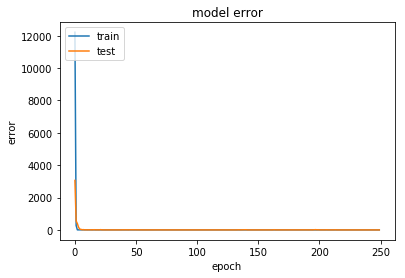

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


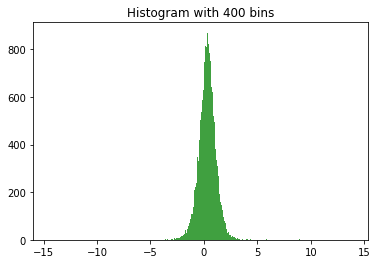

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 400
    # variables        = 3
    chi-square         = 48755.8818
    reduced chi-square = 122.810785
    Akaike info crit   = 1927.24663
    Bayesian info crit = 1939.22102
[[Variables]]
    amp:  801.014726 +/- 3.29163842 (0.41%) (init = 1000)
    cen:  0.29733463 +/- 0.00323993 (1.09%) (init = 0)
    wid:  0.96559803 +/- 0.00458195 (0.47%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



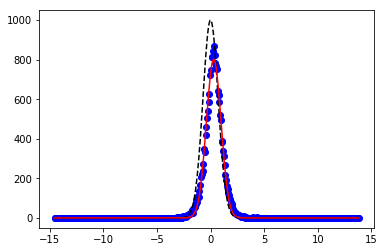

In [18]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [19]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [20]:
print(FWHM)

1.6078261764967587


[[166.55579]
 [166.57196]
 [164.14984]
 ...
 [165.36554]
 [165.12367]
 [165.43266]]


/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.9759221420204107


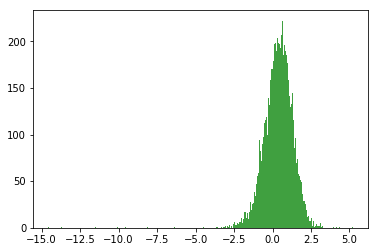

In [21]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.4823211415870494


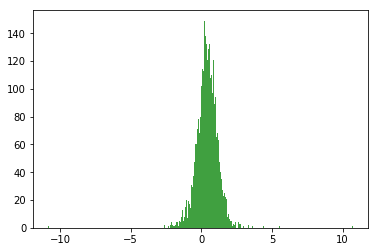

In [22]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.149213734348712


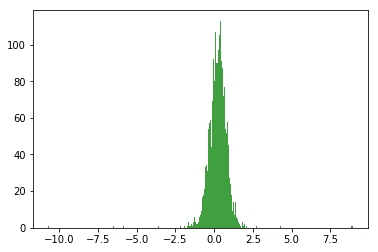

In [23]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.0892626443717939


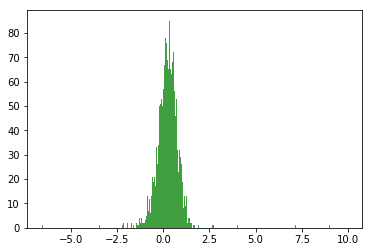

In [24]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.597488294823395
1.0892626443717939
1.149213734348712
1.4823211415870494
1.9759221420204107


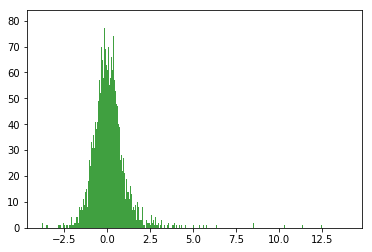

In [25]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

In [26]:
# veamosd1 =photodefbox2_todo_fil1_e[:,-9]
# veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =photodefbox2_todo_fil1_e[:,-11]
veamoser1=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,-1]
print(veamoser1.shape)
print(error_prediction.shape)
# veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
# # veerror_predictionsd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
# veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);

(20000,)
(20000,)


Veamos ahora los histogramnas 2d que nos interesan

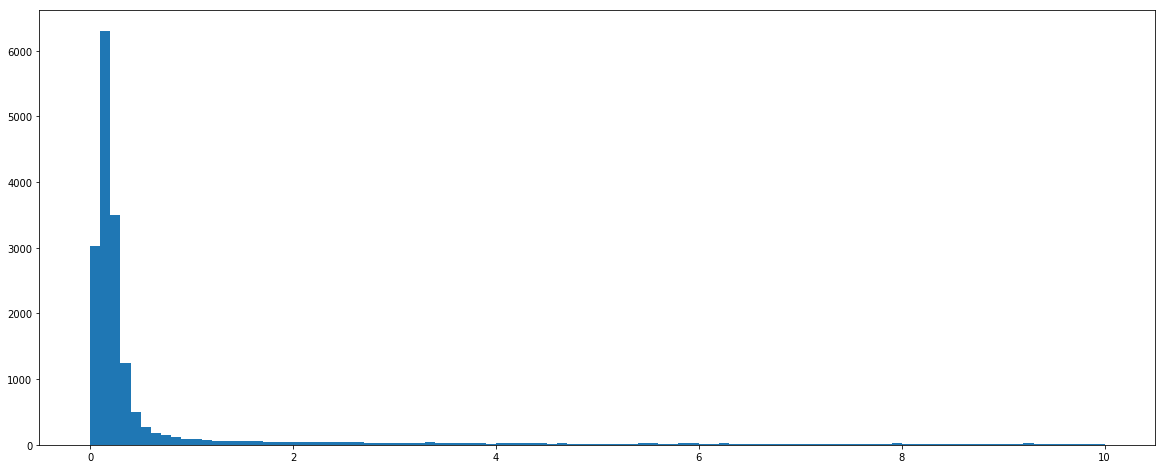

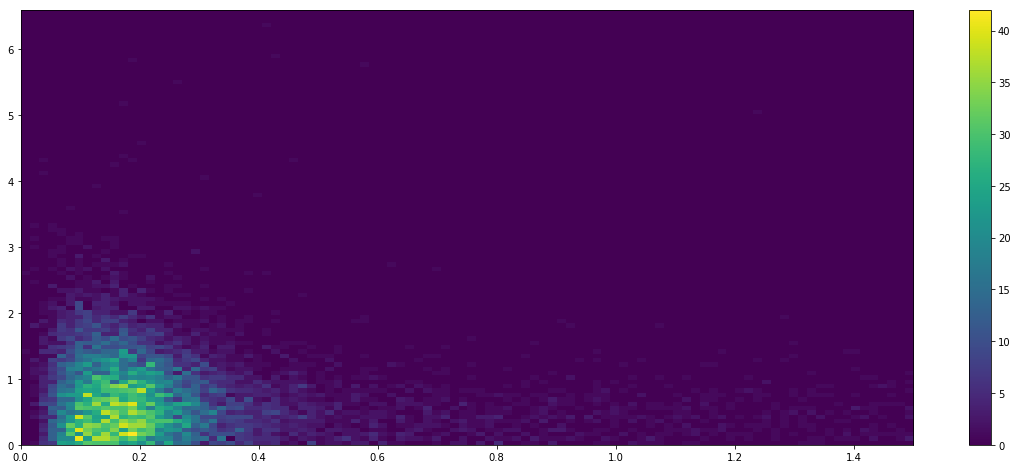

In [27]:

plt.figure(figsize=(20, 8))
plt.hist(veamoser1, bins=100, range=(0,10))

plt.figure(figsize=(20, 8))
h1=plt.hist2d(veamoser1, error_prediction, bins=100,range=[(0,1.5),(0,6.6)])
plt.colorbar(h1[3])
plt.show()

# plt.show()
# plt.figure(figsize=(20, 8))
# h2=plt.hist2d(veamoser1,veamosd1, bins=50, range=[(0,0.6),(0,0.6)])
# plt.colorbar(h2[3])
# plt.show()

# plt.figure(figsize=(20, 8))
# h3=plt.hist2d(veamoser1,veamosen1, bins=100, range=[(0,0.5),(0,0.5)])
# plt.colorbar(h3[3])
# plt.show()